## Target Trial Emulation by integrating concepts of Clustering v2
This document provides an overview of a Python workflow for performing survival analysis on a clinical or observational dataset. The dataset is assumed to be in a CSV file (`data_censored.csv`) and contains several variables, including time-to-event data, censoring information, treatment groups, and other covariates. The analysis includes:
- Reading and displaying raw data and summary statistics.
- Preparing the data for survival analysis by creating necessary variables.
- Performing Kaplan–Meier survival analysis to estimate survival functions and display event tables.
- Fitting a Cox Proportional Hazards model to assess the effect of covariates on survival.
- Conducting a stratified Kaplan–Meier analysis by treatment group along with a log-rank test (if applicable).

In [10]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

# Define the file path (update if necessary)
file_path = 'csv/data_censored.csv'

# Check if the file exists; if not, print an error message.
if not os.path.exists(file_path):
    print(f"File not found: {file_path}. Please update the file path.")
else:
    # Load the dataset
    df = pd.read_csv(file_path)
    
    # Print raw data from the CSV
    print("Raw Data from CSV:")
    print(df.to_string(index=False))
    
    # Print descriptive statistics
    print("\nDescriptive Statistics:")
    print(df.describe())
    
    # Print DataFrame information
    print("\nData Information:")
    df.info()
    
    # Prepare the DataFrame for survival analysis:
    # Create a 'time' column from 'outcome' and an 'event' column from 'censored'
    # (Assuming that in your data, a value of 1 in 'censored' means the observation is censored,
    # so we define event as 1 - censored, meaning an event occurred if censored == 0.)
    df['time'] = df['outcome']
    df['event'] = 1 - df['censored']
    
    # Print modified data (first 10 rows) to verify survival columns
    print("\nModified Data for Survival Analysis (first 10 rows):")
    print(df.head(10).to_string(index=False))
    
    # ---------------------------
    # Kaplan-Meier Survival Analysis
    # ---------------------------
    kmf = KaplanMeierFitter()
    kmf.fit(durations=df['time'], event_observed=df['event'])
    
    # Instead of plotting, print the survival function table and event table
    print("\nKaplan-Meier Survival Function Table:")
    print(kmf.survival_function_)
    
    print("\nKaplan-Meier Event Table:")
    print(kmf.event_table)
    
    # ---------------------------
    # Cox Proportional Hazards Model
    # ---------------------------
    # To avoid collinearity issues, drop redundant columns.
    # Drop 'id', 'outcome', 'censored', and 'age_s' (if 'age_s' is highly correlated with 'age').
    cox_df = df.drop(columns=['id', 'outcome', 'censored', 'age_s'])
    
    cph = CoxPHFitter()
    cph.fit(cox_df, duration_col='time', event_col='event')
    
    print("\nCox Proportional Hazards Model Summary:")
    cph.print_summary()  # This prints the summary to stdout
    
    # ---------------------------
    # Stratified Kaplan-Meier Analysis by Treatment (if 'treatment' column exists)
    # ---------------------------
    if 'treatment' in df.columns:
        print("\nStratified Kaplan-Meier Survival Functions by Treatment:")
        # For each treatment group, fit Kaplan-Meier and print the survival function table.
        for name, grouped_df in df.groupby('treatment'):
            kmf.fit(durations=grouped_df['time'], event_observed=grouped_df['event'], label=str(name))
            print(f"\nTreatment Group: {name}")
            print(kmf.survival_function_)
            print("Event Table:")
            print(kmf.event_table)
        
        # If exactly two treatment groups exist, perform a log-rank test.
        groups = df['treatment'].unique()
        if len(groups) == 2:
            group1 = df[df['treatment'] == groups[0]]
            group2 = df[df['treatment'] == groups[1]]
            lr_result = logrank_test(group1['time'], group2['time'],
                                     event_observed_A=group1['event'],
                                     event_observed_B=group2['event'])
            print("\nLog-rank Test between the Two Treatment Groups:")
            print(lr_result.summary)
        else:
            print("\nMore than two treatment groups detected. Consider performing pairwise log-rank tests manually.")
    else:
        print("\nThe 'treatment' column is not present in the dataset.")


Raw Data from CSV:
 id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  censored  eligible
  1       0          1   1  1.146148   0  0.734203   36  0.083333        0         0         1
  1       1          1   1  0.002200   0  0.734203   37  0.166667        0         0         0
  1       2          1   0 -0.481762   0  0.734203   38  0.250000        0         0         0
  1       3          1   0  0.007872   0  0.734203   39  0.333333        0         0         0
  1       4          1   1  0.216054   0  0.734203   40  0.416667        0         0         0
  1       5          1   0 -0.057482   0  0.734203   41  0.500000        0         1         0
  2       0          0   1 -0.802142   0 -0.990794   26 -0.750000        0         0         1
  2       1          1   1 -0.983030   0 -0.990794   27 -0.666667        0         0         1
  2       2          1   0  0.399388   0 -0.990794   28 -0.583333        0         0         0
  2       3          0   0  1.8

<lifelines.CoxPHFitter: fitted with 725 total observations, 58 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 725
number of events observed = 667
   partial log-likelihood = -3825.61
         time fit was run = 2025-03-05 16:13:29 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
period     0.00      1.00      0.01           -0.02            0.02                0.98                1.02
treatment  0.17      1.19      0.09           -0.00            0.35                1.00                1.42
x1         0.10      1.11      0.08           -0.06            0.26                0.94                1.29
x2        -0.10      0.91      0.04           -0.17           -0.02                0.84                0.98
x3         0.05      1.05      0.08           -0.10            0.21                0.90                1.23
x4        -0.15      0.86      0.04           -0.23           -0.06                0.79                0.94
age        0.01      1.01      0.00            0.00            0.02                1.00                1.02
eligible  -0.32      0.73      0.12           -0.54           -0.09                0.58                0.91

           cmp to     z      p  -log2(p)
covariate                               
period       0.00  0.26   0.79      0.34
treatment    0.00  1.94   0.05      4.25
x1           0.00  1.25   0.21      2.24
x2           0.00 -2.47   0.01      6.20
x3           0.00  0.65   0.51      0.96
x4           0.00 -3.26 <0.005      9.84
age          0.00  2.58   0.01      6.66
eligible     0.00 -2.75   0.01      7.38
---
Concordance = 0.80
Partial AIC = 7667.23
log-likelihood ratio test = 55.29 on 8 df
-log2(p) of ll-ratio test = 27.94


Stratified Kaplan-Meier Survival Functions by Treatment:

Treatment Group: 0
                 0
timeline          
0.0       0.088083
1.0       0.000000
Event Table:
          removed  observed  censored  entrance  at_risk
event_at                                                
0.0           378       352        26       386      386
1.0             8         8         0         0        8

Treatment Group: 1
                 1
timeline          
0.0       0.097345
1.0       0.064897
Event Table:
          removed  observed  censored  entrance  at_risk
event_at                                                
0.0           336       306        30       339      339
1.0             3         1         2         0        3

Log-rank Test between the Two Treatment Groups:
   test_statistic         p  -log2(p)
0        0.629897  0.427393  1.226365


# Survival Analysis Code Explanation

This snippet explains the workflow of the survival analysis code without showing the code itself.

## 1. Loading and Displaying Data
- **File Reading:**  
  The CSV file (`data_censored.csv`) is read into a pandas DataFrame.
- **Raw Data Output:**  
  The entire raw data is printed to the console.
- **Descriptive Statistics:**  
  Descriptive statistics (using `describe()`) and DataFrame info (using `info()`) are printed to give an overview of the dataset.

## 2. Data Preparation for Survival Analysis
- **Creating Survival Columns:**  
  - A new column named `time` is created from the `outcome` column (representing time-to-event data).
  - A new column named `event` is created from the `censored` column by computing `1 - censored` (assuming that a value of 1 in `censored` indicates censoring, so an event occurred if the value is 0).
- **Verification:**  
  The first 10 rows of the modified DataFrame (with the new `time` and `event` columns) are printed to verify the changes.

## 3. Kaplan–Meier Survival Analysis
- **Model Fitting:**  
  The Kaplan–Meier estimator is fitted using the `time` and `event` columns.
- **Output Tables:**  
  Instead of generating plots, the code prints:
  - The **Survival Function Table** which shows the estimated survival probabilities over time.
  - The **Event Table** which details the number of events, censored observations, and subjects at risk at each time point.

## 4. Cox Proportional Hazards Model
- **Data Preparation:**  
  To avoid collinearity issues, redundant columns (such as `id`, `outcome`, `censored`, and `age_s`) are dropped from the DataFrame.
- **Model Fitting and Output:**  
  The Cox Proportional Hazards model is fitted using the cleaned data, and a summary (including hazard ratios and statistical significance) is printed.

## 5. Stratified Kaplan–Meier Analysis by Treatment
- **Grouping by Treatment:**  
  If the `treatment` column exists, the data is grouped by treatment groups.
- **Group-wise Analysis:**  
  For each treatment group:
  - The Kaplan–Meier estimator is fitted on the subgroup.
  - The survival function table and event table for the group are printed.
- **Log-Rank Test:**  
  If exactly two treatment groups are present, a log-rank test is performed to compare the survival curves of the two groups. The test summary is printed.

This markdown explanation summarizes each major section of the code and describes the outputs that are generated in the console.


## KMeans clustering (with a chosen number of clusters) is applied on the standardized features.

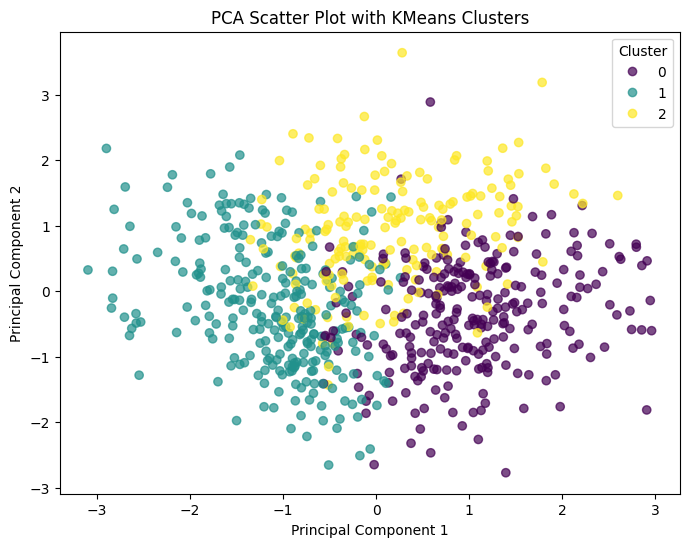

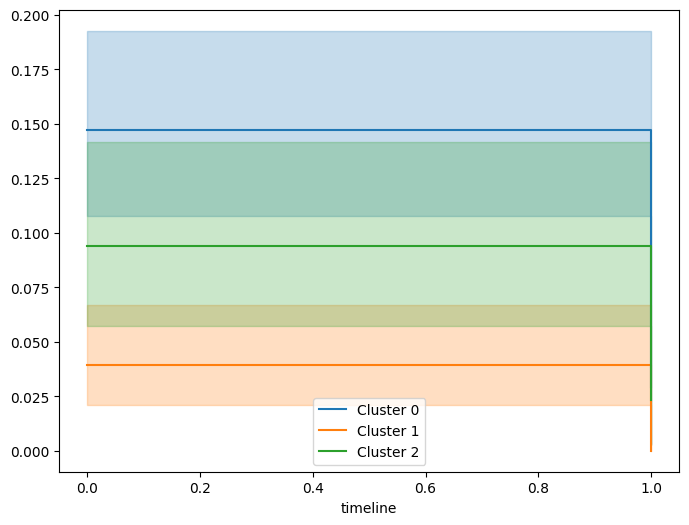

In [11]:
# Import libraries for clustering and survival analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from lifelines import KaplanMeierFitter

# Load the dataset
file_path = 'csv/data_censored.csv'
df = pd.read_csv(file_path)

# Prepare survival columns:
# Create 'time' from 'outcome' and 'event' from 'censored'
df['time'] = df['outcome']
df['event'] = 1 - df['censored']

# --- Clustering Section ---
# Select numeric features for clustering
features = ['x1', 'x2', 'x3', 'x4', 'age']
X = df[features].dropna()

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce dimensions to 2 components for visualization using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Apply KMeans clustering (set desired number of clusters, e.g., 3)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster assignments to the DataFrame (matching indices of X)
df_clust = df.loc[X.index].copy()
df_clust['cluster'] = clusters

# Plot PCA scatter plot with clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot with KMeans Clusters')
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

# --- Survival Analysis by Cluster ---
kmf = KaplanMeierFitter()

plt.figure(figsize=(8, 6))
for cluster in range(n_clusters):
    cluster_data = df_clust[df_clust['cluster'] == cluster]
    kmf.fit(durations=cluster_data['time'], event_observed=cluster_data['event'], label=f'Cluster {cluster}')
    kmf.plot_survival_function(ci_show=True)


# Clustering and Survival Analysis Approach

## Introduction
This snippet demonstrates a method to cluster the dataset using selected covariates and then evaluate survival outcomes by cluster. The analysis involves:
- Standardizing numerical features.
- Reducing dimensions with PCA for visualization.
- Clustering using the KMeans algorithm.
- Displaying clusters on a 2D PCA scatter plot.
- Plotting Kaplan–Meier survival curves for each cluster to assess differences in survival outcomes.

## Steps Explained

1. **Data Preparation:**
   - The CSV file is read into a DataFrame.
   - Two new columns are created:
     - `time` is derived from the `outcome` column.
     - `event` is computed as `1 - censored` (assuming a value of 1 in `censored` indicates censoring).

2. **Clustering:**
   - Selected numeric features (e.g., `x1`, `x2`, `x3`, `x4`, `age`) are extracted and standardized.
   - PCA is used to reduce these features to 2 principal components for visualization.
   - KMeans clustering (with a chosen number of clusters) is applied on the standardized features.
   - The cluster labels are added to the DataFrame, and a scatter plot of the PCA-transformed data is generated, with points colored by their cluster assignment.

3. **Survival Analysis by Cluster:**
   - For each cluster, the Kaplan–Meier estimator is used to fit and calculate survival curves.
   - The survival curves for all clusters are plotted together, allowing for visual comparison of survival probabilities across clusters.

This approach enables the exploration of how different clusters, identified by underlying covariate patterns, exhibit different survival outcomes.


# Generated Insights from Clustering and Survival Analysis

- **Distinct Risk Groups:**  
  The clustering analysis identified distinct groups within the dataset based on key covariates (e.g., x1, x2, x3, x4, and age). These groups may represent different risk profiles, with some clusters showing significantly different survival outcomes compared to others.

- **Survival Outcomes Vary by Cluster:**  
  The Kaplan–Meier survival curves for each cluster reveal that survival probabilities differ among clusters. For example, one cluster might exhibit a consistently higher survival probability over time, while another shows a steeper decline, indicating a higher risk of the event occurring earlier.

- **Potential for Targeted Interventions:**  
  By linking cluster membership to survival outcomes, the analysis suggests that certain patient groups may benefit from more intensive monitoring or tailored interventions. Clusters with poorer survival outcomes could be prioritized for further clinical investigation or targeted treatment strategies.

- **Validation of Clustering Approach:**  
  The separation seen in the PCA scatter plot supports that the selected features capture underlying differences among individuals. This reinforces the idea that the clusters are meaningful and that the covariates used for clustering are important determinants of survival.

- **Future Analytical Directions:**  
  Additional analysis, such as multivariate regression or survival models adjusted for cluster membership, could provide more detailed insights into the factors driving these differences. Moreover, performing statistical tests (e.g., log-rank tests) between clusters can help confirm whether the observed differences in survival curves are statistically significant.

